In [1]:
from collections import Counter
import cv2
import os
import timeit

import numpy as np
from PIL import Image
from scipy import ndimage as ndi

import skimage
from skimage import color
from skimage.morphology import skeletonize
from skimage.filters import threshold_local, threshold_mean, threshold_minimum, threshold_sauvola, threshold_otsu
from skimage.morphology import skeletonize

import rasterio
from rasterio.plot import show, adjust_band

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from utils.plotting import *
from utils.process import *


# Introduction

The purpose of this Jupyter Notebook is to show how the `TGGLinesPlus` method can be used across different domains.

## Character recognition
### MNIST

In [2]:
mnist_filename = '../data/mnist/mnist_test.csv'
mnist_images, mnist_labels = read_in_mnist(mnist_filename)
mnist_binaries = [create_binary(image) for image in mnist_images]
mnist_skeletons = [create_skeleton(binary) for binary in mnist_binaries]


In [3]:
idx_8 = 3406
label_8 = mnist_labels[idx_8]
img_8 = mnist_images[idx_8]
binary_8 = mnist_binaries[idx_8]
skeleton_8 = mnist_skeletons[idx_8]


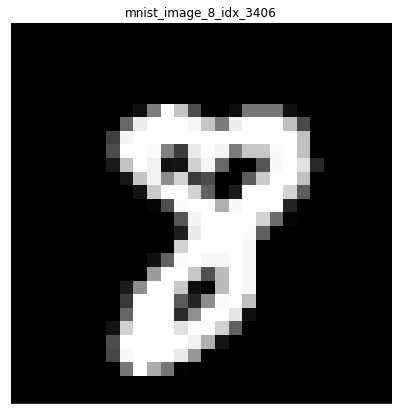

In [4]:
fig, ax = plt.subplots(1, figsize=(7, 7))

ax.imshow(img_8, cmap="gray")

ax.set_xticks([])
ax.set_yticks([]) 
ax.set_title("mnist_image_{}_idx_{}".format(label_8, idx_8))

plt.show()


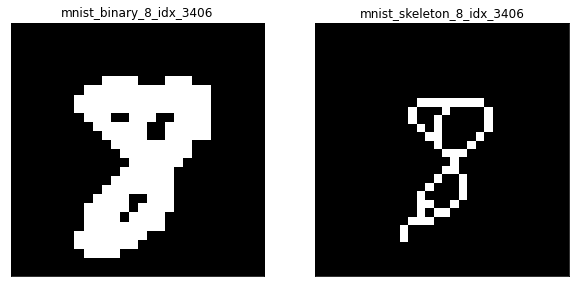

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))

ax[0].imshow(binary_8, cmap="gray")
ax[1].imshow(skeleton_8, cmap="gray")

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    
ax[0].set_title("mnist_binary_{}_idx_{}".format(label_8, idx_8))
ax[1].set_title("mnist_skeleton_{}_idx_{}".format(label_8, idx_8))

plt.show()


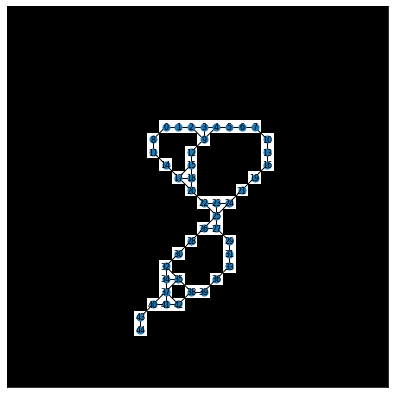

In [6]:
skeleton_array_8, coordinates_8 = create_skeleton_graph(skeleton_8, connectivity=2)
skeleton_graph_8 = nx.from_scipy_sparse_array(skeleton_array_8)
plot_networkx_graph(skeleton_8, skeleton_graph_8, coordinates_8)


In [7]:
start = timeit.default_timer()
result_dict_8 = TGGLinesPlus(skeleton_8)
stop = timeit.default_timer()

print()
print(f"Time to run: {(stop - start):.5f}s")



Time to run: 0.05368s


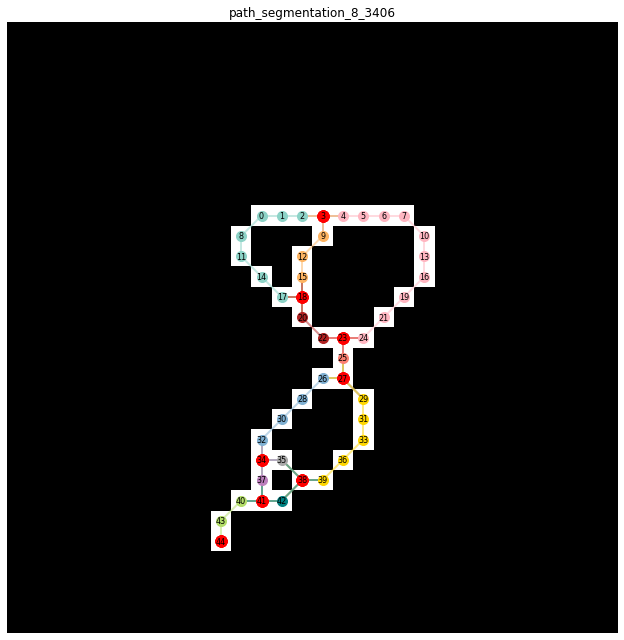

In [8]:
label = str(label_8) + "_" + str(idx_8)
plot_graph_paths(result_dict_8, label)


### Chinese MNIST

In [9]:
# I downloaded the csv version of the dataset here: https://www.kaggle.com/datasets/fedesoriano/chinese-mnist-digit-recognizer
# remember to unzip and rename the file!
cmnist_filename = '../data/mnist/chinese_mnist.csv'
cmnist_images, cmnist_labels, _ = read_in_chinese_mnist(cmnist_filename)
#threshold_mean does not work well here
cmnist_binaries = [threshold_otsu(image) < image for image in cmnist_images]
cmnist_skeletons = [create_skeleton(binary) for binary in cmnist_binaries]

print(len(cmnist_images))
print(len(cmnist_labels))


15000
15000


In [10]:
print(np.unique(cmnist_labels))


['一' '七' '万' '三' '九' '二' '五' '亿' '八' '六' '十' '千' '四' '百' '零']


In [11]:
# pick the first instance of where the characters for 0 and 4 occur
idx_0 = list(np.where(np.array(cmnist_labels) == '零')[0])[0]
idx_4 = list(np.where(np.array(cmnist_labels) == '四')[0])[0]

label_0 = 0
label_4 = 4

img_0 = cmnist_images[idx_0]
img_4 = cmnist_images[idx_4]


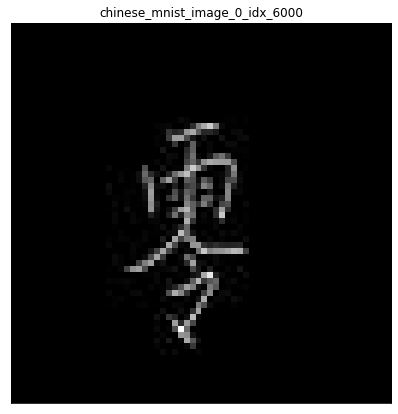

In [12]:
fig, ax = plt.subplots(1, figsize=(7, 7))

ax.imshow(img_0, cmap="gray")

ax.set_xticks([])
ax.set_yticks([]) 
ax.set_title("chinese_mnist_image_{}_idx_{}".format(label_0, idx_0))

plt.show()


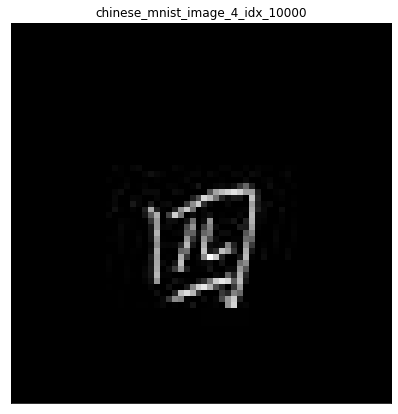

In [13]:
fig, ax = plt.subplots(1, figsize=(7, 7))

ax.imshow(img_4, cmap="gray")

ax.set_xticks([])
ax.set_yticks([]) 
ax.set_title("chinese_mnist_image_{}_idx_{}".format(label_4, idx_4))

plt.show()


In [14]:
binary_0 = cmnist_binaries[idx_0]
binary_4 = cmnist_binaries[idx_4]

skeleton_0 = cmnist_skeletons[idx_0]
skeleton_4 = cmnist_skeletons[idx_4]


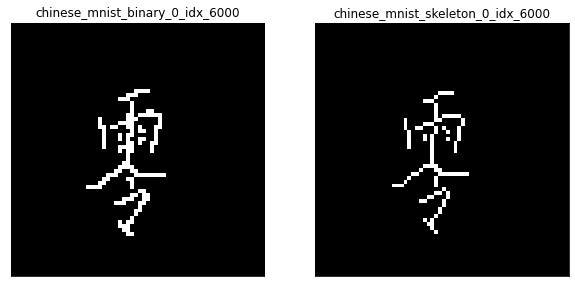

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

ax[0].imshow(binary_0, cmap="gray")
ax[1].imshow(skeleton_0, cmap="gray")

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    
ax[0].set_title("chinese_mnist_binary_{}_idx_{}".format(label_0, idx_0))
ax[1].set_title("chinese_mnist_skeleton_{}_idx_{}".format(label_0, idx_0))

plt.show()


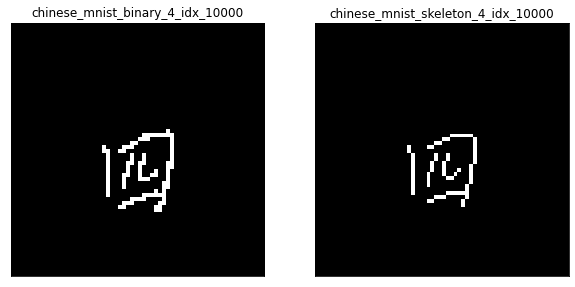

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))

ax[0].imshow(binary_4, cmap="gray")
ax[1].imshow(skeleton_4, cmap="gray")

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    
ax[0].set_title("chinese_mnist_binary_{}_idx_{}".format(label_4, idx_4))
ax[1].set_title("chinese_mnist_skeleton_{}_idx_{}".format(label_4, idx_4))

plt.show()


In [17]:
start = timeit.default_timer()
result_dict_0 = TGGLinesPlus(skeleton_0)
stop = timeit.default_timer()
print(f"Time to run: {(stop - start):.5f}s")


Time to run: 0.01525s


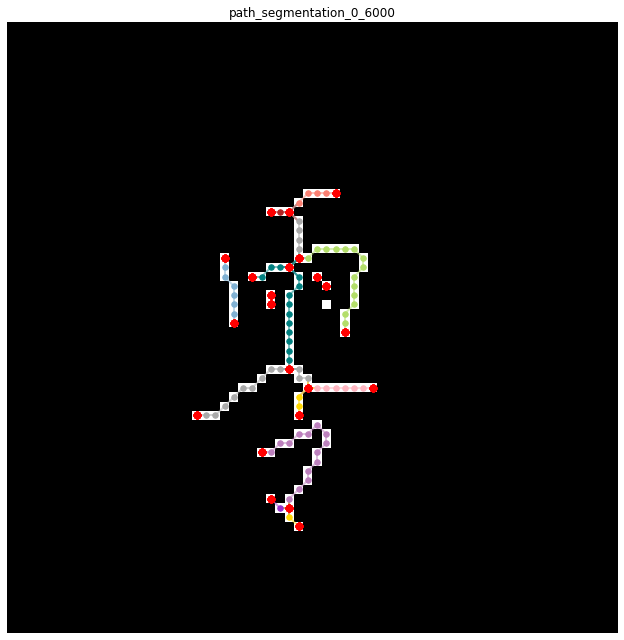

In [18]:
label = str(label_0) + "_" + str(idx_0)
plot_graph_paths(result_dict_0, label, node_size=30, node_labels=False)


In [19]:
start = timeit.default_timer()
result_dict_4 = TGGLinesPlus(skeleton_4)
stop = timeit.default_timer()
print(f"Time to run: {(stop - start):.5f}s")


Time to run: 0.00913s


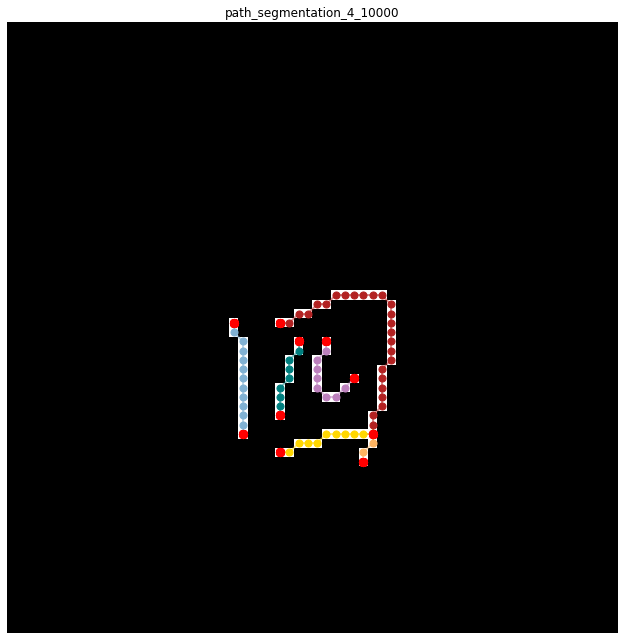

In [20]:
label = str(label_4) + "_" + str(idx_4)
plot_graph_paths(result_dict_4, label, node_size=50, node_labels=False)


### Documents

In [21]:
# https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_niblack_sauvola.html#sphx-glr-auto-examples-segmentation-plot-niblack-sauvola-py
img = skimage.data.page()

window_size = 25
thresh_page = threshold_sauvola(img, window_size=window_size)
binary_page = img < thresh_page
skeleton_page = create_skeleton(binary_page)


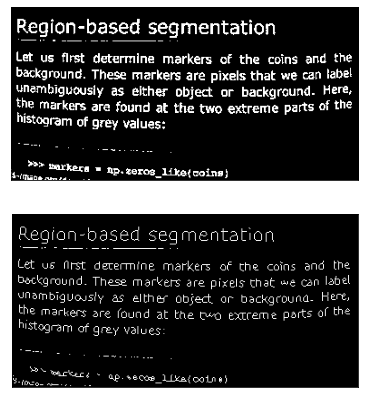

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(15, 7))

ax[0].imshow(binary_page, cmap="gray")
ax[1].imshow(skeleton_page, cmap="gray")

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])

plt.show()


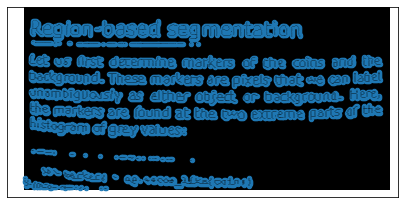

In [23]:
skeleton_array_page, coordinates_page = create_skeleton_graph(skeleton_page, connectivity=2)
skeleton_graph_page = nx.from_scipy_sparse_array(skeleton_array_page)

plot_options = {
    "node_size": 20,
    "font_size": 0,
}

fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(skeleton_page, cmap="gray")
nx.draw_networkx(skeleton_graph_page, pos=reverse_coordinates(coordinates_page), ax=ax, **plot_options)

plt.margins(0)

plt.show()


In [24]:
start = timeit.default_timer()
result_dict_page = TGGLinesPlus(skeleton_page)
stop = timeit.default_timer()

print()
print(f"Time to run: {(stop - start):.5f}s")



Time to run: 53.49566s


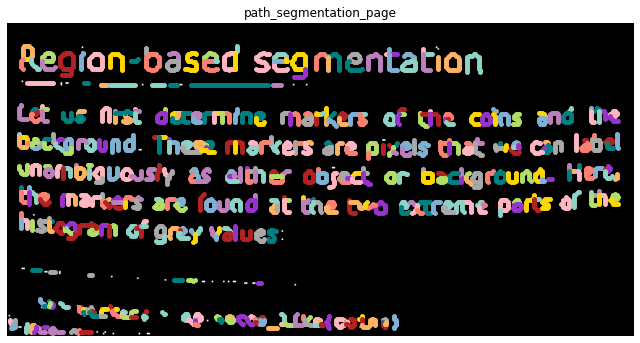

In [25]:
plot_graph_paths(result_dict_page, "page", node_size=15, endpoints=False, node_labels=False)


## Health


In [26]:
#https://scikit-image.org/docs/stable/auto_examples/applications/plot_pixel_graphs.html#sphx-glr-auto-examples-applications-plot-pixel-graphs-py
img = skimage.data.retina()
retina = color.rgb2gray(img)
t0, t1 = skimage.filters.threshold_multiotsu(retina, classes=3)
mask = (retina > t0)
vessels = skimage.filters.sato(retina, sigmas=range(1, 10)) * mask


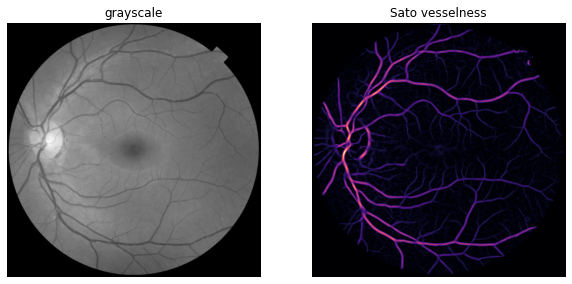

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))

ax[0].imshow(retina, cmap='gray')
ax[1].imshow(vessels, cmap='magma')

ax[0].set_axis_off()
ax[1].set_axis_off()

ax[0].set_title('grayscale')
ax[1].set_title('Sato vesselness')

plt.show()


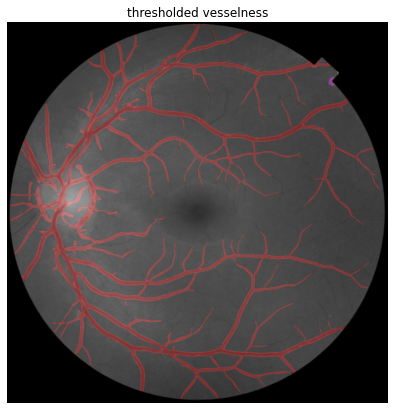

In [28]:
thresholded = skimage.filters.apply_hysteresis_threshold(vessels, 0.01, 0.03)
labeled = ndi.label(thresholded)[0]

fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(color.label2rgb(labeled, retina))

ax.set_axis_off()
ax.set_title('thresholded vesselness')

plt.show()


In [29]:
largest_nonzero_label = np.argmax(np.bincount(labeled[labeled > 0]))
binary_retina = labeled == largest_nonzero_label
skeleton_retina = skeletonize(binary_retina)


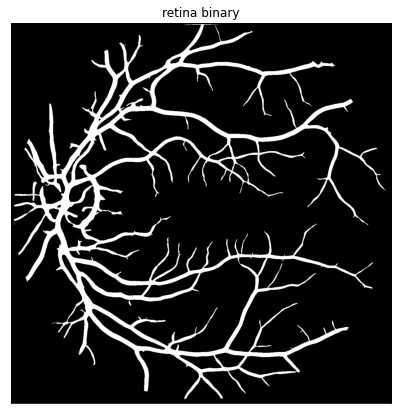

In [30]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(binary_retina, cmap="gray")

ax.set_xticks([])
ax.set_yticks([])
ax.set_title("retina binary")

plt.show()


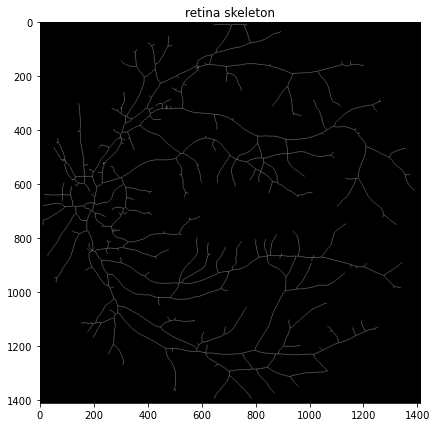

In [31]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(skeleton_retina, cmap="gray")

axis.set_xticks([])
axis.set_yticks([])
ax.set_title("retina skeleton")

plt.show()

It is hard to see, but the skeleton is there.

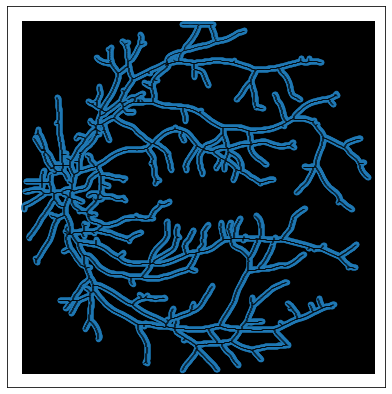

In [32]:
skeleton_array_retina, coordinates_retina = create_skeleton_graph(skeleton_retina, connectivity=2)
skeleton_graph_retina = nx.from_scipy_sparse_array(skeleton_array_retina)

plot_options = {
    "node_size": 20,
    "font_size": 0,
}

fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(skeleton_retina, cmap="gray")
nx.draw_networkx(skeleton_graph_retina, pos=reverse_coordinates(coordinates_retina), ax=ax, **plot_options)

plt.margins(0)

plt.show()


In [33]:
start = timeit.default_timer()
result_dict_retina = TGGLinesPlus(skeleton_retina)
stop = timeit.default_timer()
print(f"Time to run: {(stop - start):.5f}s")


Time to run: 26.53684s


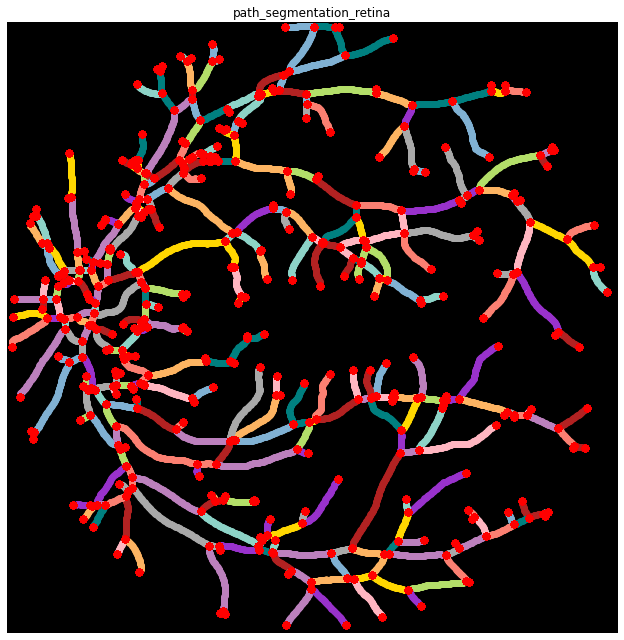

In [34]:
plot_graph_paths(result_dict_retina, "retina", node_size=30, node_labels=False)


Let's choose a smaller portion of the image to focus on.

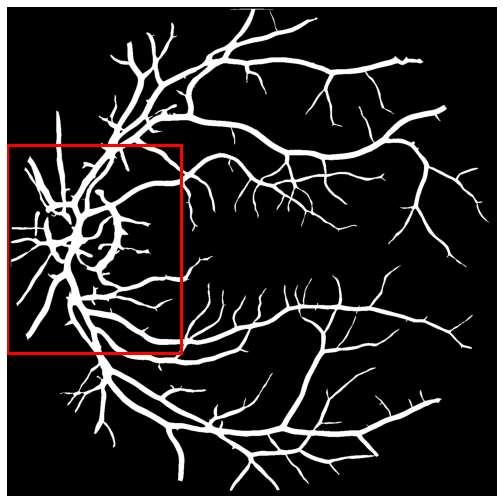

In [35]:
patch_options = {
    "linewidth": 3,
    "edgecolor": "r",
    "facecolor": "none",
}

fig, ax = plt.subplots(figsize=(9, 9))

ax.imshow(binary_retina, cmap="gray")

# https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html
# add rectangles around areas of interest in the image
middle_patch = patches.Rectangle((0, 400), 500, 600, **patch_options)

ax.add_patch(middle_patch)

plt.axis("off")
plt.show()


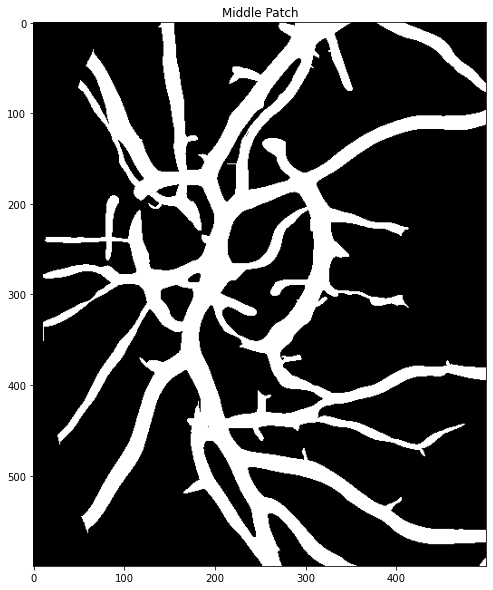

In [36]:
binary_retina_small = binary_retina[400:1000, 0:500] # [600, 500]

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(binary_retina_small, cmap="gray")

ax.set_title("Middle Patch")
# ax[0].axis("off")

plt.show()


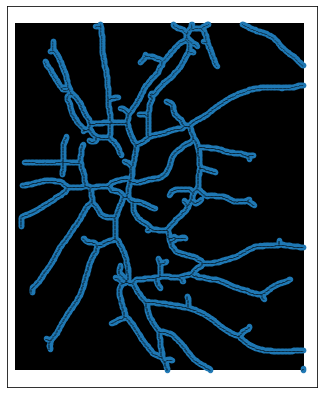

In [37]:
skeleton_retina_small = skeleton_retina[400:1000, 0:500]

skeleton_array_retina, coordinates_retina = create_skeleton_graph(skeleton_retina_small, connectivity=2)
skeleton_graph_retina = nx.from_scipy_sparse_array(skeleton_array_retina)

plot_options = {
    "node_size": 20,
    "font_size": 0,
}

fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(skeleton_retina_small, cmap="gray")
nx.draw_networkx(skeleton_graph_retina, pos=reverse_coordinates(coordinates_retina), ax=ax, **plot_options)

plt.margins(0)
plt.show()


In [38]:
start = timeit.default_timer()
result_dict_retina_small = TGGLinesPlus(skeleton_retina_small)
stop = timeit.default_timer()
print(f"Time to run: {(stop - start):.5f}s")


Time to run: 2.94793s


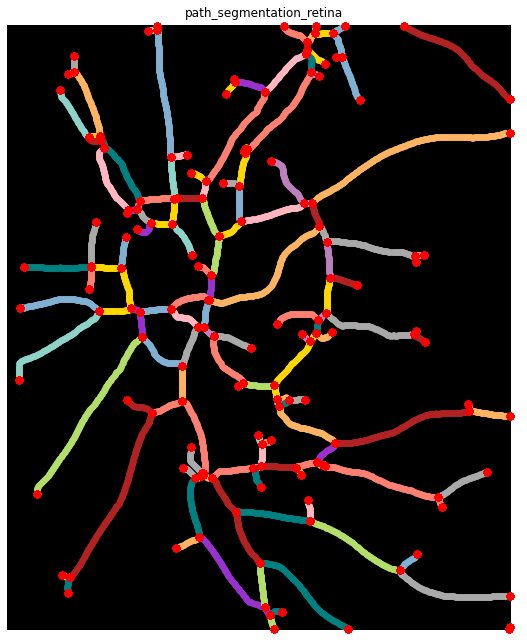

In [39]:
plot_graph_paths(result_dict_retina_small, "retina", node_size=30, node_labels=False)

## Massachusetts roads

In [40]:
road_name = '11278840_15.tif'
road_path = '../data/mass_roads/' + road_name
road_array = open_tiff(road_path)
road_array


/Users/joshuadriscoll/miniconda3/envs/skeleton_graph/lib/python3.9/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [41]:
road_array.shape


(1500, 1500)

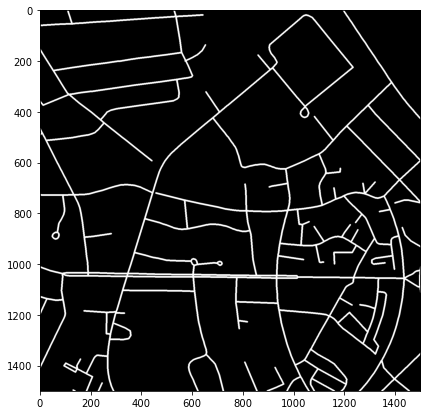

In [42]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(road_array, cmap="gray")

plt.show()


In [43]:
binary_road = create_binary(road_array)
skeleton_road = create_skeleton(binary_road)

skeleton_array_road, coordinates_road = create_skeleton_graph(skeleton_road, connectivity=2)
skeleton_graph_road = nx.from_scipy_sparse_array(skeleton_array_road)
search_by_node_road, search_by_location_road = get_node_locations(coordinates_road)


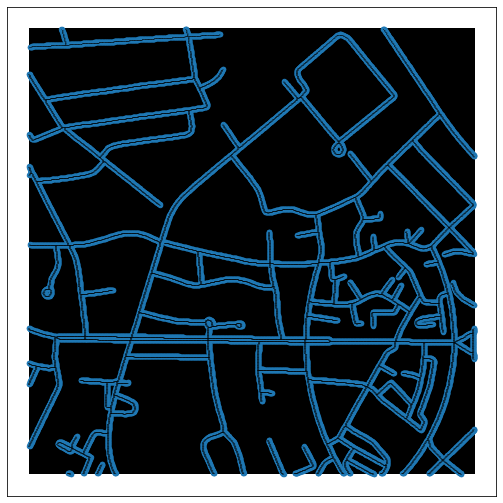

In [44]:
plot_options = {
    "node_size": 20,
    "font_size": 0,
}

fig, ax = plt.subplots(figsize=(9, 9))

ax.imshow(skeleton_road, cmap="gray")
nx.draw_networkx(skeleton_graph_road, pos=reverse_coordinates(coordinates_road), ax=ax, **plot_options)

plt.margins(0)

plt.show()


In [45]:
start = timeit.default_timer()
result_dict_roads = TGGLinesPlus(skeleton_road)
stop = timeit.default_timer()
print(f"Time to run: {(stop - start):.5f}s")


Time to run: 13.33127s


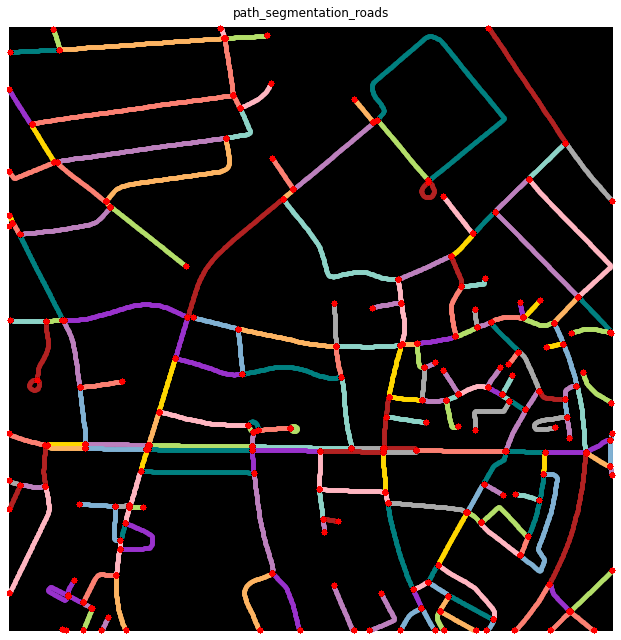

In [46]:
plot_graph_paths(result_dict_roads, "roads", node_size=10, node_labels=False)


Let's choose a smaller portion of the image to focus on.

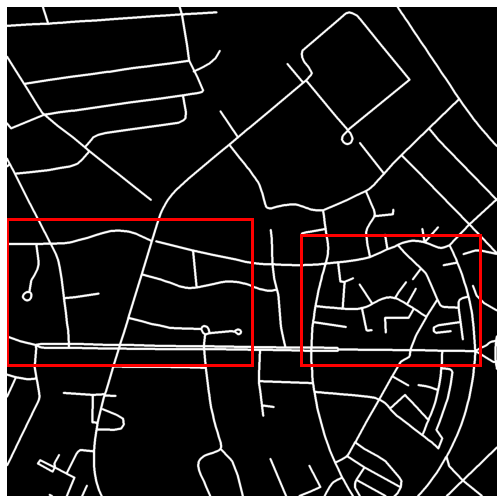

In [47]:
patch_options = {
    "linewidth": 3,
    "edgecolor": "r",
    "facecolor": "none",
}

fig, ax = plt.subplots(figsize=(9, 9))

ax.imshow(road_array, cmap="gray")

# https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html
# add rectangles around areas of interest in the image
middle_patch = patches.Rectangle((0, 650), 750, 450, **patch_options)
bottom_patch = patches.Rectangle((900, 700), 550, 400, **patch_options)

ax.add_patch(middle_patch)
ax.add_patch(bottom_patch)

plt.axis("off")
plt.show()


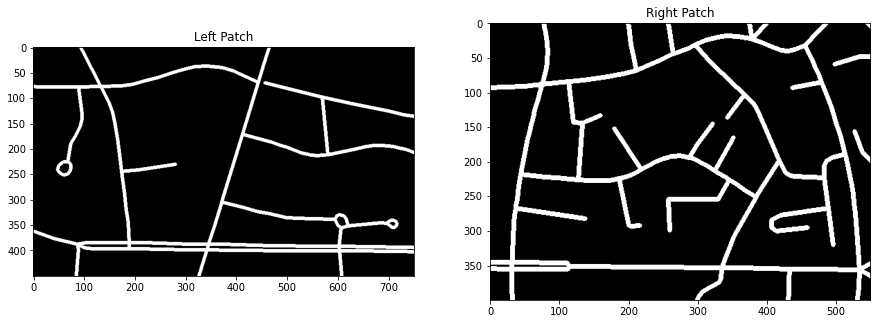

In [48]:
road_left = road_array[650:1100, 0:750] # [450, 750]
road_right = road_array[700:1100, 900:1450] # [400, 550]


fig, ax = plt.subplots(1, 2, figsize=(15, 15))

ax[0].imshow(road_left, cmap="gray")
ax[1].imshow(road_right, cmap="gray")

ax[0].set_title("Left Patch")
ax[1].set_title("Right Patch")

# ax[0].axis("off")
# ax[1].axis("off")

plt.show()


In [49]:
road_left_binary = create_binary(road_left)
road_right_binary = create_binary(road_right)

road_left_skeleton = create_skeleton(road_left_binary)
road_right_skeleton = create_skeleton(road_right_binary)


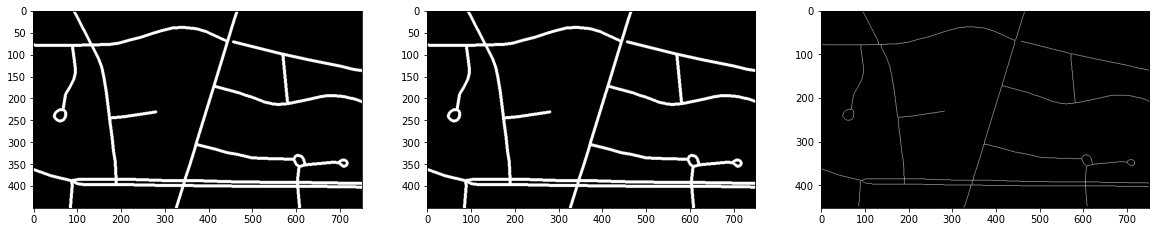

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(20, 15))

ax[0].imshow(road_left, cmap="gray")
ax[1].imshow(road_left_binary, cmap="gray")
ax[2].imshow(road_left_skeleton, cmap="gray")

plt.show()


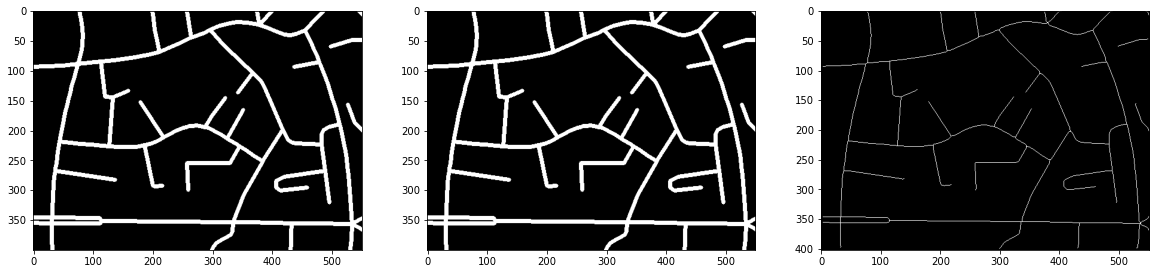

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(20, 15))

ax[0].imshow(road_right, cmap="gray")
ax[1].imshow(road_right_binary, cmap="gray")
ax[2].imshow(road_right_skeleton, cmap="gray")

plt.show()


In [52]:
road_left_array, road_left_coordinates = create_skeleton_graph(road_left_skeleton, connectivity=2)
road_left_graph = nx.from_scipy_sparse_array(road_left_array)

road_right_array, road_right_coordinates = create_skeleton_graph(road_right_skeleton, connectivity=2)
road_right_graph = nx.from_scipy_sparse_array(road_right_array)


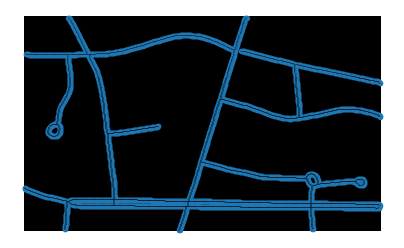

In [53]:
plot_options = {
    "node_size": 20,
    "font_size": 0,
}

fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(road_left_skeleton, cmap="gray")
nx.draw_networkx(road_left_graph, pos=reverse_coordinates(road_left_coordinates), ax=ax, **plot_options)

plt.margins(0)
plt.axis("off")

plt.show()


In [54]:
start = timeit.default_timer()
result_dict_road_left = TGGLinesPlus(road_left_skeleton)
stop = timeit.default_timer()

print()
print(f"Time to run: {(stop - start):.5f}s")



Time to run: 0.65154s


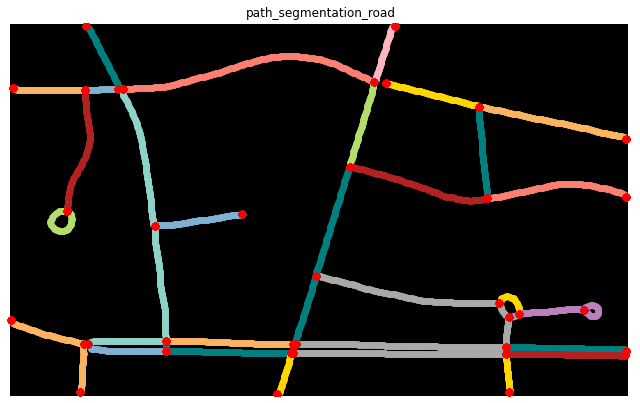

In [55]:
plot_graph_paths(result_dict_road_left, "road", node_size=30, node_labels=False)


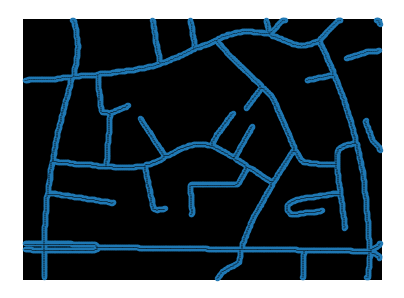

In [56]:
plot_options = {
    "node_size": 20,
    "font_size": 0,
}

fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(road_right_skeleton, cmap="gray")
nx.draw_networkx(road_right_graph, pos=reverse_coordinates(road_right_coordinates), ax=ax, **plot_options)

plt.margins(0)
plt.axis("off")

plt.show()


In [57]:
start = timeit.default_timer()
result_dict_road_right = TGGLinesPlus(road_right_skeleton)
stop = timeit.default_timer()

print()
print(f"Time to run: {(stop - start):.5f}s")



Time to run: 1.08523s


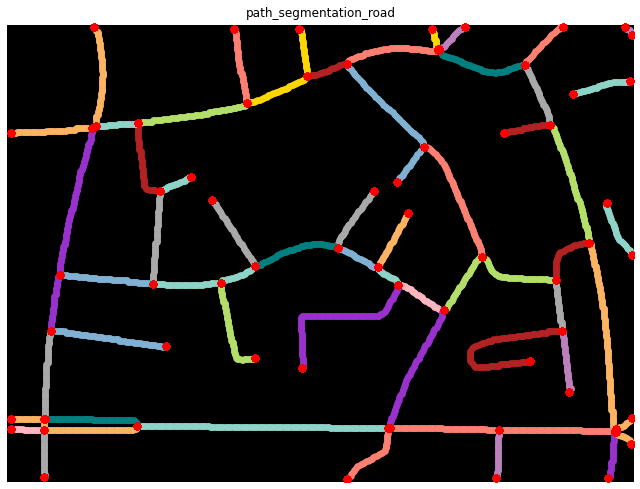

In [58]:
plot_graph_paths(result_dict_road_right, "road", node_size=30, node_labels=False)


## DeepCrack

In [59]:
cement_name = '../data/deepcrack/11215-5.png'
image_cement = np.asarray(Image.open(cement_name).convert("L"))
print(image_cement.shape)


(384, 544)


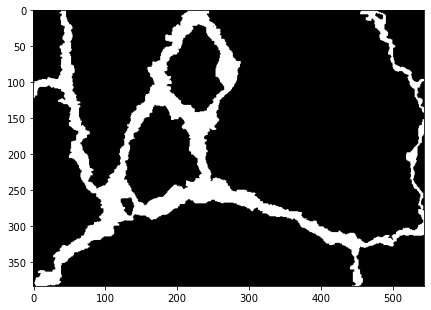

In [60]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(image_cement, cmap="gray")

plt.show()

In [61]:
binary_cement = create_binary(image_cement)
skeleton_cement = create_skeleton(binary_cement)

skeleton_array_cement, coordinates_cement = create_skeleton_graph(skeleton_cement, connectivity=2)
skeleton_graph_cement = nx.from_scipy_sparse_array(skeleton_array_cement)


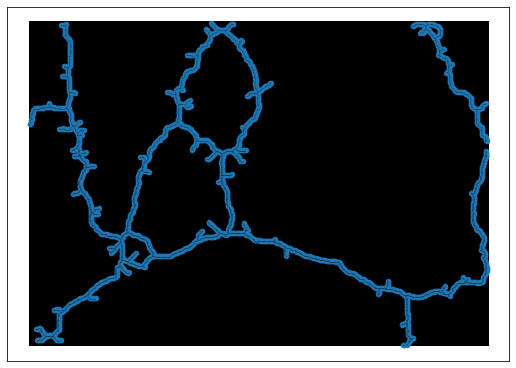

In [62]:
plot_options = {
    "node_size": 20,
    "font_size": 0,
}

fig, ax = plt.subplots(figsize=(9, 9))

ax.imshow(skeleton_cement, cmap="gray")
nx.draw_networkx(skeleton_graph_cement, pos=reverse_coordinates(coordinates_cement), ax=ax, **plot_options)

plt.margins(0)

plt.show()


In [63]:
start = timeit.default_timer()
result_dict_cement = TGGLinesPlus(skeleton_cement)
stop = timeit.default_timer()
print(f"Time to run: {(stop - start):.5f}s")


Time to run: 1.44107s


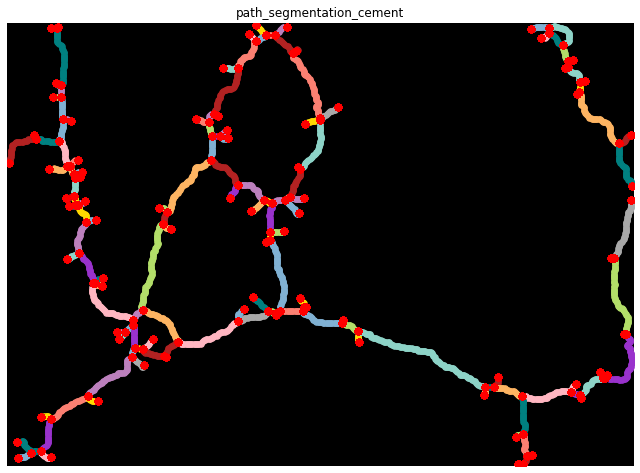

In [64]:
plot_graph_paths(result_dict_cement, "cement", node_size=30, node_labels=False)


## Satellite imagery
### Ice sheet imagery Landsat

In [66]:
landsat_location_1 = '../data/rs_imagery/test_image1.png'
landsat_location_2 = '../data/rs_imagery/test_image2.png'
landsat_location_3 = '../data/rs_imagery/test_image3.png'

# these images have RGBA channels, convert them to grayscale
landsat_array_1 = np.asarray(Image.open(landsat_location_1).convert("L"))
landsat_array_2 = np.asarray(Image.open(landsat_location_2).convert("L"))
landsat_array_3 = np.asarray(Image.open(landsat_location_3).convert("L"))


In [67]:
print(landsat_array_1.shape)
print(landsat_array_2.shape)
print(landsat_array_3.shape)


(177, 191)
(277, 266)
(520, 416)


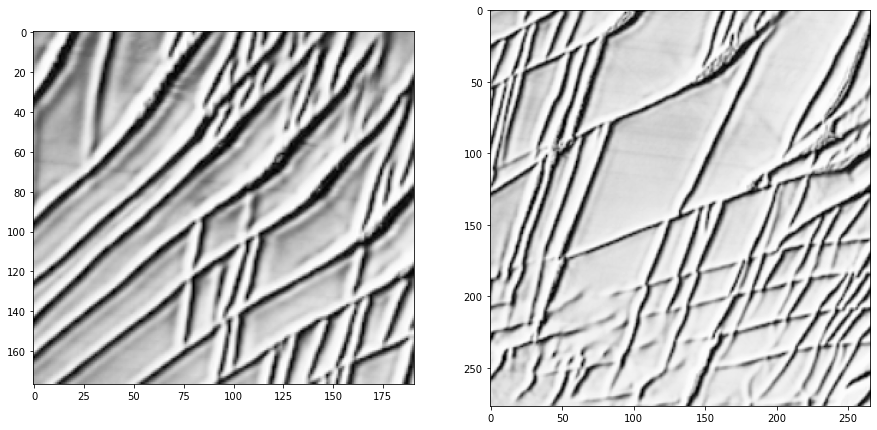

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

ax[0].imshow(landsat_array_1, cmap="gray")
ax[1].imshow(landsat_array_2, cmap="gray")

plt.show()


Let's start with the image on the left, simply because it is smaller.

In [69]:
binary_landsat = create_binary_reverse(landsat_array_1)
skeleton_landsat = create_skeleton(binary_landsat)


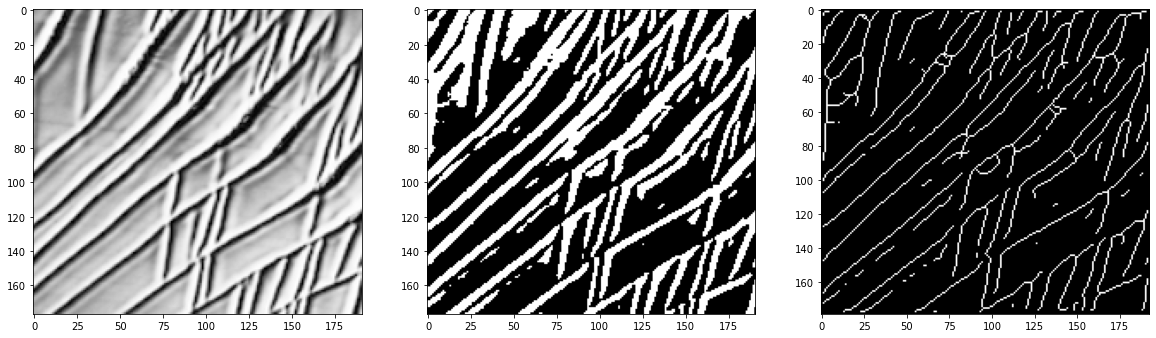

In [70]:
fig, ax = plt.subplots(1, 3, figsize=(20, 15))

ax[0].imshow(landsat_array_1, cmap="gray")
ax[1].imshow(binary_landsat, cmap="gray")
ax[2].imshow(skeleton_landsat, cmap="gray")

plt.show()


In [71]:
skeleton_array_landsat, coordinates_landsat = create_skeleton_graph(skeleton_landsat, connectivity=2)
skeleton_graph_landsat = nx.from_scipy_sparse_array(skeleton_array_landsat)


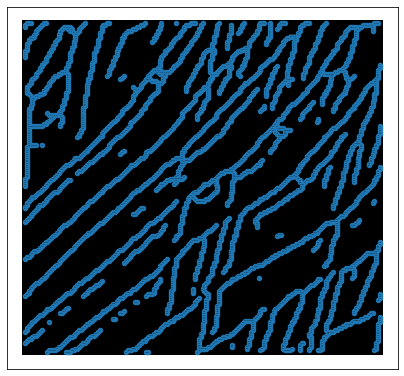

In [72]:
plot_options = {
    "node_size": 20,
    "font_size": 0,
}

fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(skeleton_landsat, cmap="gray")
nx.draw_networkx(skeleton_graph_landsat, pos=reverse_coordinates(coordinates_landsat), ax=ax, **plot_options)

plt.margins(0)

plt.show()


In [73]:
start = timeit.default_timer()
result_dict_landsat = TGGLinesPlus(skeleton_landsat)
stop = timeit.default_timer()

print(f"Time to run: {(stop - start):.5f}s")


Time to run: 2.01995s


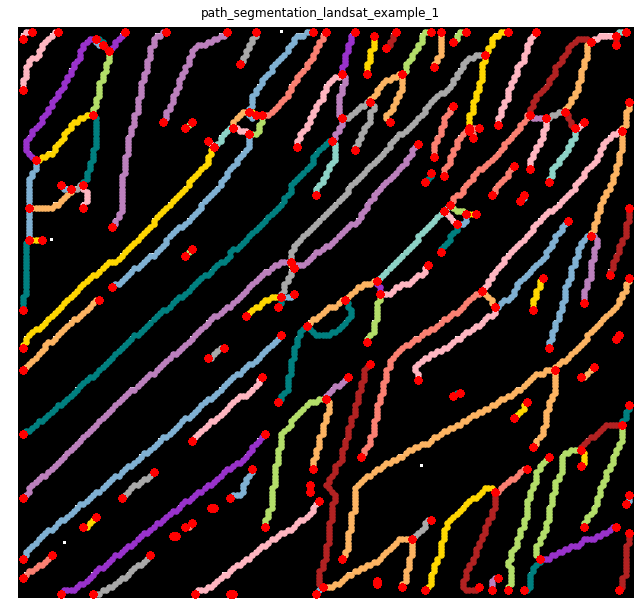

In [74]:
plot_graph_paths(result_dict_landsat, "landsat_example_1", node_size=30, node_labels=False)


And now the second image?

In [81]:
binary_landsat = create_binary_reverse(landsat_array_2)
skeleton_landsat = create_skeleton(binary_landsat)

skeleton_array_landsat, coordinates_landsat = create_skeleton_graph(skeleton_landsat, connectivity=2)
skeleton_graph_landsat = nx.from_scipy_sparse_array(skeleton_array_landsat)


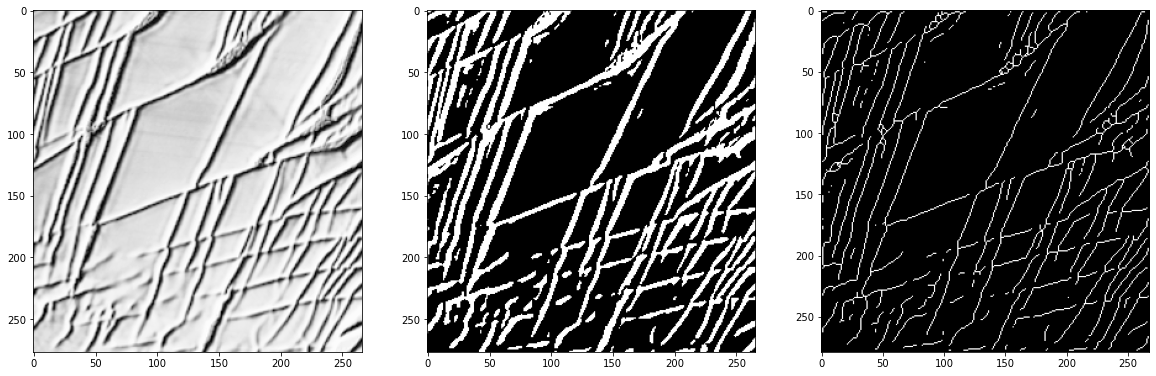

In [82]:
fig, ax = plt.subplots(1, 3, figsize=(20, 15))

ax[0].imshow(landsat_array_2, cmap="gray")
ax[1].imshow(binary_landsat, cmap="gray")
ax[2].imshow(skeleton_landsat, cmap="gray")

plt.show()


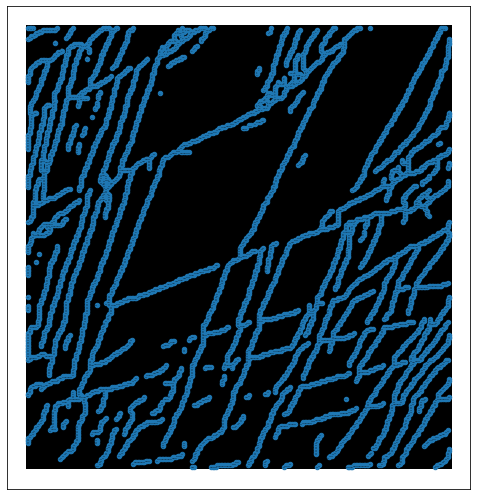

In [83]:
plot_options = {
    "node_size": 20,
    "font_size": 0,
}

fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(skeleton_landsat, cmap="gray")
nx.draw_networkx(skeleton_graph_landsat, pos=reverse_coordinates(coordinates_landsat), ax=ax, **plot_options)

plt.margins(0)
plt.tight_layout()

plt.show()


In [84]:
start = timeit.default_timer()
result_dict_landsat = TGGLinesPlus(skeleton_landsat)
stop = timeit.default_timer()

print(f"Time to run: {(stop - start):.5f}s")


Time to run: 7.32676s


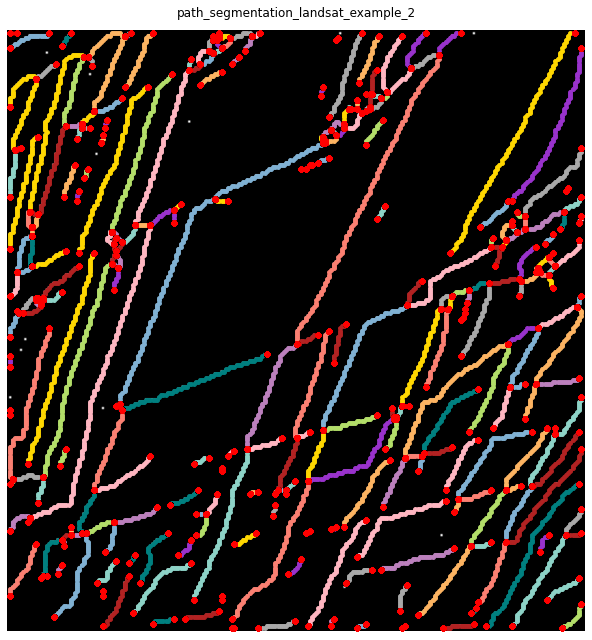

In [85]:
plot_graph_paths(result_dict_landsat, "landsat_example_2", node_size=15, node_labels=False)
